In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [13]:

#import creep data
creep_df = pd.read_csv('../PI_Data/PI_Ti_alloys_dataset.csv')
creep_df

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress,Creep Life
0,89.980,5.79,3.86,0.07,0.030,0.000,0.000,0.12,0.0,0.00,...,800,0.67,800,0.66,1.100000e-05,3.90,0.729,700,45.0,1.00
1,87.810,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0,0.00,0,0.00,1.390000e-04,0.00,-4.529,600,319.0,0.17
2,89.256,6.33,4.00,0.20,0.030,0.010,0.004,0.17,0.0,0.00,...,0,0.00,190,6.00,1.570000e-04,17.40,-4.529,600,319.0,0.17
3,87.810,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0,0.00,950,1.00,1.390000e-04,17.40,-4.529,600,319.0,0.17
4,82.340,5.60,5.08,0.95,0.000,0.000,0.000,0.00,0.0,0.00,...,0,0.00,0,0.00,0.000000e+00,1.30,2.266,400,250.0,72.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,88.250,6.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,0.00,...,1050,0.50,550,24.00,1.440000e-07,26.22,2.474,500,300.0,328.28
149,48.000,48.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,2.00,...,0,0.00,1260,4.00,9.060000e-07,1.76,2.512,750,325.0,192.36
150,87.875,6.75,4.50,0.40,0.100,0.050,0.125,0.20,0.0,0.00,...,690,4.00,1050,0.50,9.720000e-08,11.20,2.512,500,319.0,224.00
151,85.260,5.70,0.00,0.00,0.040,0.000,0.000,0.00,4.8,0.69,...,1050,0.50,700,2.00,0.000000e+00,7.05,2.259,600,310.0,91.45


In [14]:
# Log transform of creep rupture life, then convert data type to float32
creep_df['log_creep_life'] = np.log10(creep_df['Creep Life'])
creep_df = creep_df.drop(['Creep Life'], axis=1)
creep_df = creep_df.astype('float32')
creep_df

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress,log_creep_life
0,89.980003,5.79,3.86,0.07,0.030,0.000,0.000,0.12,0.0,0.00,...,800.0,0.67,800.0,0.66,1.100000e-05,3.900000,0.729,700.0,45.0,0.000000
1,87.809998,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0.0,0.00,0.0,0.00,1.390000e-04,0.000000,-4.529,600.0,319.0,-0.769551
2,89.255997,6.33,4.00,0.20,0.030,0.010,0.004,0.17,0.0,0.00,...,0.0,0.00,190.0,6.00,1.570000e-04,17.400000,-4.529,600.0,319.0,-0.769551
3,87.809998,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0.0,0.00,950.0,1.00,1.390000e-04,17.400000,-4.529,600.0,319.0,-0.769551
4,82.339996,5.60,5.08,0.95,0.000,0.000,0.000,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.000000e+00,1.300000,2.266,400.0,250.0,1.857332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,88.250000,6.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,0.00,...,1050.0,0.50,550.0,24.00,1.440000e-07,26.219999,2.474,500.0,300.0,2.516244
149,48.000000,48.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,2.00,...,0.0,0.00,1260.0,4.00,9.060000e-07,1.760000,2.512,750.0,325.0,2.284115
150,87.875000,6.75,4.50,0.40,0.100,0.050,0.125,0.20,0.0,0.00,...,690.0,4.00,1050.0,0.50,9.720000e-08,11.200000,2.512,500.0,319.0,2.350248
151,85.260002,5.70,0.00,0.00,0.040,0.000,0.000,0.00,4.8,0.69,...,1050.0,0.50,700.0,2.00,0.000000e+00,7.050000,2.259,600.0,310.0,1.961184


In [15]:
creep_df.sort_values(by=['log_creep_life'], ascending=True, ignore_index=True, inplace=True)
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Ti                               153 non-null    float32
 1   Al                               153 non-null    float32
 2   V                                153 non-null    float32
 3   Fe                               153 non-null    float32
 4   C                                153 non-null    float32
 5   N                                153 non-null    float32
 6   H                                153 non-null    float32
 7   O                                153 non-null    float32
 8   Sn                               153 non-null    float32
 9   Nb                               153 non-null    float32
 10  Mo                               153 non-null    float32
 11  Zr                               153 non-null    float32
 12  Si                    

In [16]:
# Extract features and targets
features = creep_df.iloc[:, 0:24]
targets = creep_df.iloc[:, 24]
features

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress
0,87.875000,6.75,4.50,0.40,0.100,0.050,0.1250,0.20,0.00,0.0,...,0.0,690.0,4.0,1050.0,0.5,2.090000e-03,15.800000,-0.136,700.0,319.0
1,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,3.240000e-06,0.000000,-0.136,600.0,319.0
2,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,4.400000e-05,0.000000,-0.073,600.0,250.0
3,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,4.430000e-05,0.000000,2.470,500.0,520.0
4,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,2.130000e-03,0.000000,0.318,700.0,319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,85.987000,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,0.0,...,0.0,900.0,1.0,580.0,8.0,1.200000e-04,0.000000,2.458,520.0,310.0
149,89.043404,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0.0,0.0,940.0,4.0,9.160000e-07,0.000000,2.664,455.0,379.0
150,89.043404,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0.0,0.0,1030.0,0.5,1.270000e-06,0.000000,2.664,455.0,379.0
151,89.410004,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,9.000000e-07,22.299999,2.323,538.0,103.0


In [17]:
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1


Pearson CC: 0.9086208959968161
R2 score: 0.82029211048132
RMSE: 0.4975520381828189
MAE: 0.3670443888324542
Coverage: 99.99999999999994
Pearson R2 median: 0.9086208959968161
R2 median: 0.82029211048132
RMSE median: 0.4975520381828189
Interval Width: 1.7213559203098665
Composite Metric: 0.8952343452334924


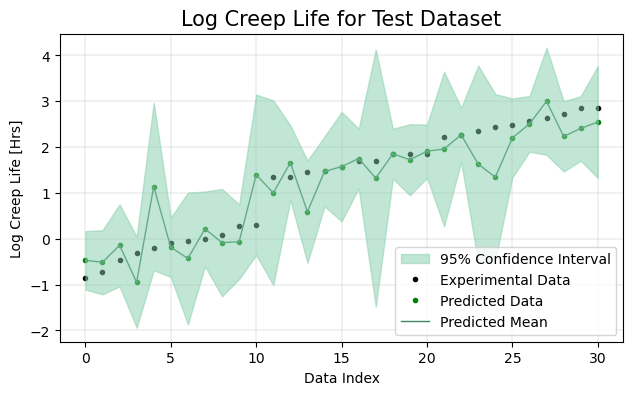

********************
Run # 1 Fold # 2
Pearson CC: 0.9374047256580114
R2 score: 0.8719988153865851
RMSE: 0.5164187079919731
MAE: 0.36255431174956015
Coverage: 90.32258064516124
Pearson R2 median: 0.9374047256580114
R2 median: 0.8719988153865851
RMSE median: 0.5164187079919731
Interval Width: 1.5955937590384475
Composite Metric: 0.8341008400750626


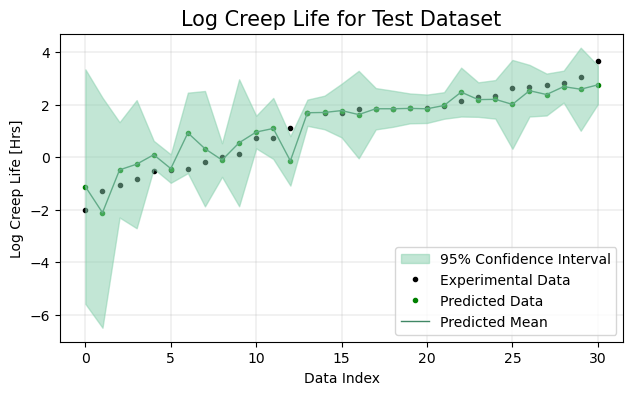

********************
Run # 1 Fold # 3
Pearson CC: 0.9259104328336093
R2 score: 0.854761457822358
RMSE: 0.5150248496131321
MAE: 0.36006817219679227
Coverage: 93.54838709677414
Pearson R2 median: 0.9259104328336093
R2 median: 0.854761457822358
RMSE median: 0.5150248496131321
Interval Width: 2.0142134584963625
Composite Metric: 0.8257308307202574


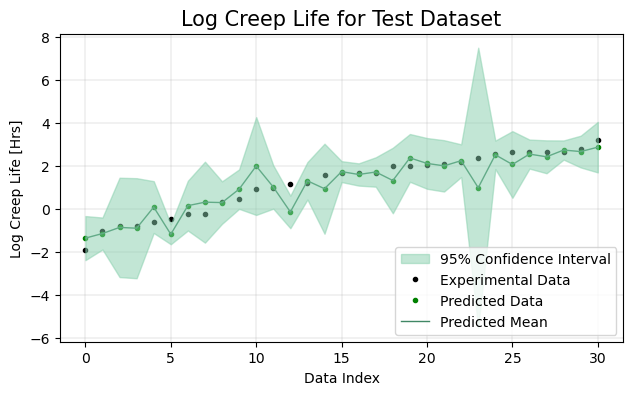

********************
Run # 1 Fold # 4
Pearson CC: 0.886693269708335
R2 score: 0.7678214302000264
RMSE: 0.5707869775339041
MAE: 0.42005707133813647
Coverage: 93.33333333333331
Pearson R2 median: 0.886693269708335
R2 median: 0.7678214302000264
RMSE median: 0.5707869775339041
Interval Width: 1.644407001393282
Composite Metric: 0.852030488673533


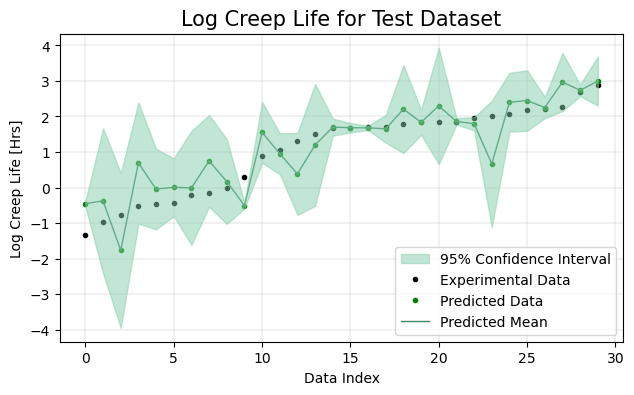

********************
Run # 1 Fold # 5
Pearson CC: 0.8822108978430729
R2 score: 0.7765279639400491
RMSE: 0.5151669645672924
MAE: 0.33422854809960806
Coverage: 93.33333333333331
Pearson R2 median: 0.8822108978430729
R2 median: 0.7765279639400491
RMSE median: 0.5151669645672924
Interval Width: 1.434346078038545
Composite Metric: 0.8742954533970437


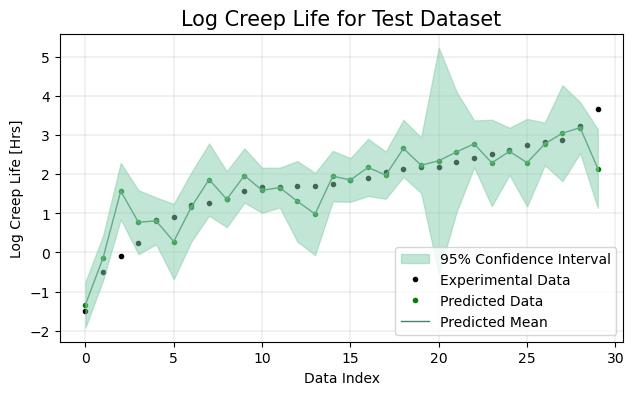

********************


In [18]:
# Evaluate multiple runs of the model
nruns = 1

nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)


test_coverage = np.zeros_like(PearsonCC)

median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
       
            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')


            print(f"Pearson R2 median: {pearsonr(y_test, df_test_median)[0]}")
            print(f"R2 median: {r2_score(y_test, df_test_median)}")
            print(f"RMSE median: {np.sqrt(mean_squared_error(y_test, df_test_median))}")

            
            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test 
            y_std = y_pred_unc_test
            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            fig.delaxes(ax[1])

            plt.show()

            print(20*'*')

In [19]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.908621,0.820292,0.497552,0.367044,100.000000
1,0.937405,0.871999,0.516419,0.362554,90.322581
2,0.925910,0.854761,0.515025,0.360068,93.548387
3,0.886693,0.767821,0.570787,0.420057,93.333333
4,0.882211,0.776528,0.515167,0.334229,93.333333


In [20]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.908168,0.02147,0.81828,0.041255,0.52299,0.024898,0.36879,0.028074,94.107527,3.179888


In [21]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,100.000000,1.721356,0.895234
1,90.322581,1.595594,0.834101
2,93.548387,2.014213,0.825731
3,93.333333,1.644407,0.852030
4,93.333333,1.434346,0.874295


In [22]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,94.107527,3.179888,1.681983,0.190854,0.856278,0.025633
